In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('.', one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels

ntrain = trainimgs.shape[0]
ntest = testimgs.shape[0]
dim = trainimgs.shape[1]
nclasses = trainlabels.shape[1]

print("Train Images : ", trainimgs.shape)
print("Train Labels: ", trainlabels.shape)

print ("")

print("Test Images : ", testimgs.shape)
print("Test Labels: ", testlabels.shape)

Train Images :  (55000, 784)
Train Labels:  (55000, 10)

Test Images :  (10000, 784)
Test Labels:  (10000, 10)


**Let's get one one sample, just to understand the structure of MNIST dataset**

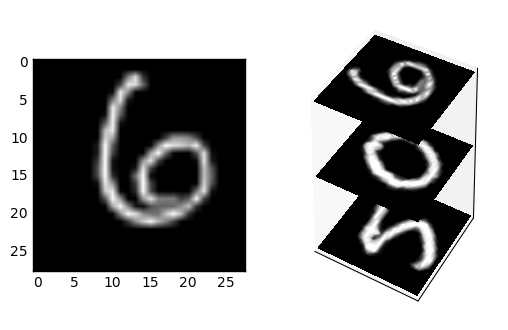

Sample 100 has label 6
Sample 101 has label 0
Sample 102 has label 5


In [4]:
sampleIdx = [100, 101, 102]
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(testimgs[sampleIdx[0]].reshape([28,28]), cmap='gray')


xx, yy = np.meshgrid(np.linspace(0, 28, 28), np.linspace(0, 28, 28))
X = xx; Y = yy
Z = 100 *np.ones(X.shape)

img = testimgs[77].reshape([28, 28])
ax = fig.add_subplot(122, projection='3d')
ax.set_zlim((0, 200))

offset = 200
for i in sampleIdx:
    img = testimgs[i].reshape([28,28]).transpose()
    ax.contourf(X, Y, img, 200, zdir='z', offset=offset, cmap='gray')
    offset-=100
    
    ax.set_xticks([])

ax.set_yticks([])
ax.set_zticks([])

plt.show()

for i in sampleIdx:
    print("Sample {0} has label {1}".format(i, np.argmax(testlabels[i], 0)))

## RNN Model

Simple RNN model consists of:
    - One input layer which converts a 28 dimensional input to an 128 dimensional hidden layer
    - One intermediate recurrent neural network (LSTM)
    - One output layer which converts the 128 dimensional output of LSTM to
    10 dimensional output indicating a  class label

In [5]:
n_input = 28  # MNIST data input 
n_steps = 28   # timesteps
n_hidden = 128  # hidden layer num of features
n_classes = 10  # MNIST number of classes

learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

### Construct a recurrent neural network

In [6]:
x = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_input], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name="y")

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}

biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [7]:
def RNN(x, weights, biases):
    # prepare the data to match `rnn` function requirements
    # current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape  (batch_size, n_input)
    
    # Permuting the batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    
    x = tf.split(split_dim=0, num_split=n_steps, value=x)
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    
    # Get the lstm cell output
    outputs, states = rnn.rnn(cell=lstm_cell, inputs=x, dtype=tf.float32)
    
    return tf.matmul(outputs[-1], weights['out'] + biases['out'])

In [8]:
with tf.variable_scope("forward"):
    pred = RNN(x, weights, biases)
    
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [13]:
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        # 128x784
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        # Reshape data to get 28 seq of 28 elements
        batch_xs = batch_xs.reshape([batch_xs.shape[0], n_steps, n_input])
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x:batch_xs, y: batch_ys})
        
        if step% display_step==0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x:batch_xs, y: batch_ys})
            
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})
            print ("Iter {0} :=> Minibatch loss = {1:0.6f}, Accuracy = {2:.5f}".format(step*batch_size, loss, acc))
        step += 1
    print ("Optimization finished.")
    
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing accuracy : ", sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Iter 1280 :=> Minibatch loss = 1.617134, Accuracy = 0.44531
Iter 2560 :=> Minibatch loss = 1.240504, Accuracy = 0.59375
Iter 3840 :=> Minibatch loss = 1.018494, Accuracy = 0.67188
Iter 5120 :=> Minibatch loss = 1.211648, Accuracy = 0.60938
Iter 6400 :=> Minibatch loss = 0.853179, Accuracy = 0.75000
Iter 7680 :=> Minibatch loss = 0.703337, Accuracy = 0.78125
Iter 8960 :=> Minibatch loss = 0.555733, Accuracy = 0.81250
Iter 10240 :=> Minibatch loss = 0.385642, Accuracy = 0.85938
Iter 11520 :=> Minibatch loss = 0.411568, Accuracy = 0.89062
Iter 12800 :=> Minibatch loss = 0.502027, Accuracy = 0.82812
Iter 14080 :=> Minibatch loss = 0.348567, Accuracy = 0.88281
Iter 15360 :=> Minibatch loss = 0.344079, Accuracy = 0.88281
Iter 16640 :=> Minibatch loss = 0.286736, Accuracy = 0.92188
Iter 17920 :=> Minibatch loss = 0.208489, Accuracy = 0.93750
Iter 19200 :=> Minibatch loss = 0.236897, Accuracy = 0.94531
Iter 20480 :=> Minibatch loss = 0.198803, Accuracy = 0.92969
Iter 21760 :=> Minibatch loss =

In [11]:
sess.close()